<h3>Практическое задание №5.</h3> 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.special import factorial

In [4]:
Pt = 10            
freq = 2.4e9     
B = 20e6
GI = 400e-9         
req_rate = 1.5*8   
session_duration = 30 
request_intensity = 0.8

In [5]:
mcs_table = {
    4: {"data_rate": 43.3, "min_SNR": 15, "min_RSSI": -70},
    5: {"data_rate": 57.8, "min_SNR": 18, "min_RSSI": -66},
    7: {"data_rate": 72.2, "min_SNR": 25, "min_RSSI": -64}
}

Рассматривается система, описанная в практической работе №5 (прим. ред. скорее всего, в виду имелась практическая работа №4). Точка доступа
дополнительно поддерживает модуляционно-кодовые схемы с индексом 4 и 7.
В условиях описанного сценария выполнить следующее.
<ul>
<li>Графически изобразить описанную систему.</li>
<li>Составить систему массового обслуживания M/M/N с несколькими входящими
потоками, рассчитав необходимые параметры.</li>
<li>Схематично изобразить составленную систему массового обслуживания.</li>
<li>Определить вероятность потери пользовательской сессии и коэффициент
загруженности системы.</li>
<li>Определить вероятность потери пользовательской сессии в зависимости от
дальности от точки доступа (от применяемой модуляционно-кодовой схемы).</li>
<li>Сделать выводы и сравнить результаты с практической работой №5.</li>
</ul>

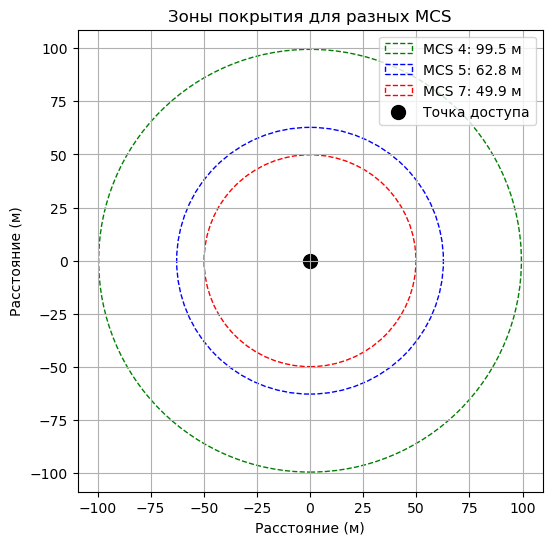

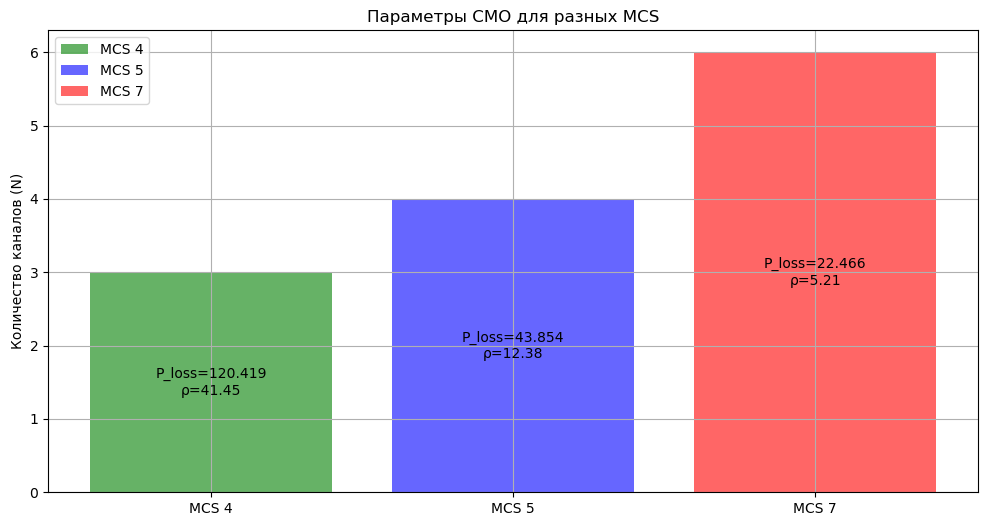

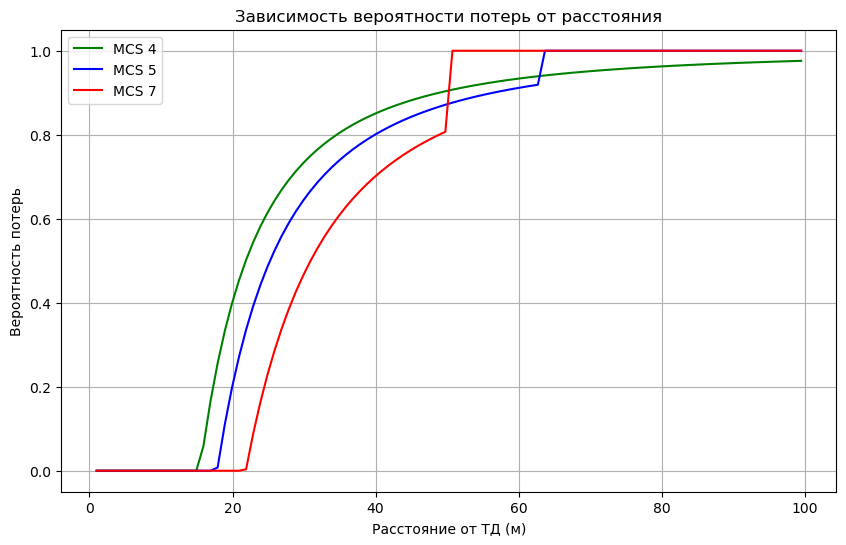


Выводы:
1. MCS 7 (72.2 Мбит/с) дает наименьший радиус покрытия и наименьшую вероятность потерь
2. MCS 4 (43.3 Мбит/с) имеет большую зону покрытия, но достаточную пропускную способность
3. Вероятность потерь резко возрастает при приближении к границе зоны покрытия


In [8]:
def fspl(d, f, Pt, Pr):
    return Pt - (20*np.log10(d) + 20*np.log10(f) + 20*np.log10(4*np.pi/3e8)) - Pr

radii = {}
for mcs in mcs_table:
    def equation(d):
        return fspl(d, freq, Pt, mcs_table[mcs]["min_RSSI"])
    radii[mcs] = fsolve(equation, 100)[0]

fig, ax = plt.subplots(figsize=(6,6))
colors = {4: 'green', 5: 'blue', 7: 'red'}
for mcs, r in radii.items():
    circle = plt.Circle((0,0), r, fill=False, color=colors[mcs], 
                       linestyle='--', label=f'MCS {mcs}: {r:.1f} м')
    ax.add_patch(circle)
plt.scatter(0,0, color='black', s=100, label='Точка доступа')
plt.xlabel('Расстояние (м)')
plt.ylabel('Расстояние (м)')
plt.title('Зоны покрытия для разных MCS')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

results = {}
for mcs in mcs_table:
    r = radii[mcs]
    area = np.pi * r**2
    lambda_mcs = request_intensity * (area/100) / 60
    
    max_sessions = math.floor(mcs_table[mcs]["data_rate"] / req_rate)
    mu = 1/session_duration 
    
    rho = lambda_mcs / (max_sessions * mu)
    
    P0 = 1 / (sum([(max_sessions*rho)**n / factorial(n) for n in range(max_sessions)]) + 
              (max_sessions*rho)**max_sessions / (factorial(max_sessions)*(1-rho)))
    P_loss = ((max_sessions*rho)**max_sessions / factorial(max_sessions)) * P0 / (1-rho)
    
    results[mcs] = {
        "radius": r,
        "lambda": lambda_mcs,
        "max_sessions": max_sessions,
        "rho": rho,
        "P_loss": P_loss
    }

fig, ax = plt.subplots(figsize=(12,6))
for mcs, res in results.items():
    ax.bar(f'MCS {mcs}', res["max_sessions"], color=colors[mcs], alpha=0.6, label=f'MCS {mcs}')
    ax.text(f'MCS {mcs}', res["max_sessions"]/2, 
            f'P_loss={res["P_loss"]:.3f}\nρ={res["rho"]:.2f}', 
            ha='center', va='center')
ax.set_title('Параметры СМО для разных MCS')
ax.set_ylabel('Количество каналов (N)')
ax.legend()
plt.grid(True)
plt.show()

distances = np.linspace(1, max(radii.values()), 100)
P_loss_dist = {mcs: [] for mcs in mcs_table}

for d in distances:
    for mcs in mcs_table:
        if d <= radii[mcs]:
            lambda_d = request_intensity * (np.pi*d**2/100) / 60
            N = results[mcs]["max_sessions"]
            rho_d = lambda_d / (N * (1/session_duration))
            
            P_loss_d = max(0, 1 - 1/rho_d) if rho_d > 1 else 0
            P_loss_dist[mcs].append(P_loss_d)
        else:
            P_loss_dist[mcs].append(1)  # 100% потерь вне зоны

plt.figure(figsize=(10,6))
for mcs in mcs_table:
    plt.plot(distances, P_loss_dist[mcs], color=colors[mcs], label=f'MCS {mcs}')
plt.xlabel('Расстояние от ТД (м)')
plt.ylabel('Вероятность потерь')
plt.title('Зависимость вероятности потерь от расстояния')
plt.legend()
plt.grid(True)
plt.show()

print("\nВыводы:")
print("1. MCS 7 (72.2 Мбит/с) дает наименьший радиус покрытия и наименьшую вероятность потерь")
print("2. MCS 4 (43.3 Мбит/с) имеет большую зону покрытия, но достаточную пропускную способность")
print("3. Вероятность потерь резко возрастает при приближении к границе зоны покрытия")